In [41]:
import numpy as np
import pandas as pd
import IPython
import os
import h5py

from pydub import AudioSegment
from scipy.io import wavfile
from matplotlib import pyplot as plt

%matplotlib inline


In [42]:
background_folder = os.path.join('data', 'background')
negative_folder = os.path.join('data', 'negative')
positive_folder = os.path.join('data', 'positive')

background_filename = os.path.join(background_folder, '42.wav')
negative_filename = os.path.join(negative_folder, '1.wav')
positive_filename = os.path.join(positive_folder, 'rec.wav')

In [43]:
IPython.display.Audio(background_filename)

In [44]:
def draw_spectogram(filename):
    samplingFrequency, signalData = wavfile.read(filename)
    
    dims = signalData.ndim
    
    if dims == 2:
        signalData = signalData[:,0]
    
    plt.subplot(2, 1, 1)
    plt.plot(signalData)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    plt.subplot(212)
    pxx, freqs, bins, im = plt.specgram(signalData, Fs=samplingFrequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.plot()
    return pxx

def draw_spectogram_without_plot(filename):
    samplingFrequency, signalData = wavfile.read(filename)
    
    dims = signalData.ndim
    
    if dims == 2:
        signalData = signalData[:,0]
    
    pxx, freqs, bins, im = plt.specgram(signalData, Fs=samplingFrequency)
    return pxx


def get_random_timesegment(segment):
    start = np.random.randint(low=0, high=10000 - segment)
    end = start + segment - 1
    return (start, end)

def is_overlaping(segment, previous_segments):
    start, end = segment
    is_overlaping = False
    for p_start, p_end in previous_segments:
        if start <= p_end and end >= p_start:
            is_overlaping = True
        
    return is_overlaping

def insert_audio_clip(audio, background, previous_segments):
    
    segment_ms = len(audio)
    
    segment_time = get_random_timesegment(segment_ms)
    
    count = 5
    while is_overlaping(segment_time, previous_segments):
        segment_time = get_random_timesegment(segment_ms)
        
    previous_segments.append(segment_time)
    new_background = background.overlay(audio, position=segment_time[0])
    return new_background, segment_time
    

def insert_ones(y, segment_end_ms, Ty):
    
    segment_end = int(segment_end_ms * Ty/ 10000.0)
    
    for i in range(segment_end, segment_end + 50):
        if i < Ty:
            y[0, i] = 1
    
    return y

def load_audio(dir_name):
    files = []
    for file in os.listdir(dir_name):
        if not file.endswith('wav'):
            continue
        audio = AudioSegment.from_wav(os.path.join(dir_name, file))
        files.append(audio)
    return files

def save_h5(filename, data):  
    with h5py.File(filename, "w") as f:
        f.create_dataset("data", data=data)
        
def load_h5(filename):
    f = h5py.File(filename, 'r')
    return f['data'][:]

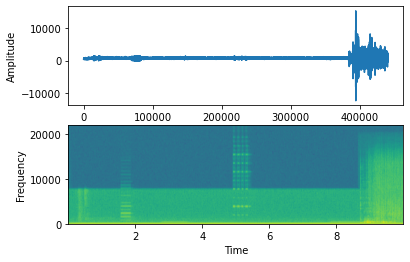

In [45]:
X = draw_spectogram(background_filename)

In [46]:
_, data = wavfile.read(background_filename)
print('Frequency htz',data.shape)
print('After spectogram ',X.shape)

Frequency htz (441000,)
After spectogram  (129, 3444)


In [47]:
Tx = 3444 # timesteps
n_freq = 129
Ty= 860 # (3444 - 8)/4 + 1

In [48]:
def create_training_example(background, positives , negatives):
        
    # quiter background
    background = background - 20
    y = np.zeros((1, Ty))
    
    previous_segments = []
    
    # actives
    num_of_positives = np.random.randint(0, 5)
    random_indices = np.random.randint(len(positives), size=num_of_positives)
    random_positives = [positives[i] for i in random_indices]
    
    for random_positive in random_positives:
        background, segment_time = insert_audio_clip(random_positive, background, previous_segments)
        srg_start, seg_end = segment_time
        y = insert_ones(y, seg_end, Ty)
        
    
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]
    
    print('--HERE --')
    
    for random_negative in random_negatives:
        background, _ = insert_audio_clip(random_negative, background, previous_segments)
    
    change_in_dBFS =  -20.0 - background.dBFS
    background.apply_gain(change_in_dBFS)
    
    file_handle = background.export("train" + ".wav", format="wav")
    
    X = draw_spectogram_without_plot('train.wav')
    
    return X, y
    

In [49]:
backgrounds = load_audio(background_folder)
positives = load_audio(positive_folder)
negatives = load_audio(negative_folder)

PermissionError: [Errno 13] Permission denied: 'data\\positive\\rec1.wav'

In [38]:
X, y = create_training_example(backgrounds[0], positives , negatives)

NameError: name 'positives' is not defined

In [52]:
IPython.display.Audio('train.wav')


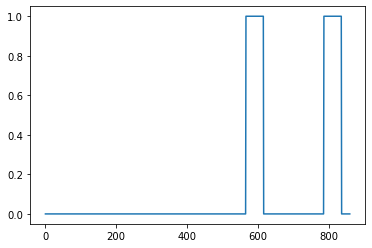

In [53]:
plt.plot(y.T)

In [19]:
dataset_size = 1000

def create_training_dataset():
    X_train = np.zeros((dataset_size, Tx, n_freq))
    y_train = np.zeros((dataset_size, Ty))
    
    
    for i in range(dataset_size):
        background_index = np.random.randint(0, 6)
        print('created ', i)
        X, y = create_training_example(backgrounds[background_index], positives , negatives)
        X_train[i,:,:] = X.T
        y_train[i] = y
        
    return X_train, y_train
        
    
        

In [20]:
X_train, y_train = create_training_dataset()


created  0
created  1
created  2
created  3
created  4
created  5
created  6
created  7
created  8
created  9
created  10
created  11
created  12
created  13
created  14
created  15
created  16
created  17
created  18
created  19
created  20
created  21
created  22
created  23
created  24
created  25


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000154129E7A68> (for post_execute):


KeyboardInterrupt: 

In [16]:
save_h5('X_train', X_train)
save_h5('y_train', y_train)

In [17]:
X_train = load_h5('X_train')
y_train = load_h5('y_train')

In [18]:
# y_train = np.expand_dims(y_train, -1)
# print(X_train.shape)
# print(y_train.shape)

X_train = np.array(X_train, dtype='float64')
X_train.dtype

dtype('<f8')

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Conv1D, BatchNormalization, Activation, Dropout, TimeDistributed, Dense

tf.__version__

'2.0.0'

In [20]:
def create_model():
    
    model = Sequential([
        Input(shape=(Tx, n_freq)),
        Conv1D(filters=196, kernel_size=8, strides=4),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.7),
        
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.7),
        
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.7),
        
        TimeDistributed(Dense(1, activation='sigmoid'))
    ])
    
    return model
    
    

In [21]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 860, 196)          202468    
_________________________________________________________________
batch_normalization (BatchNo (None, 860, 196)          784       
_________________________________________________________________
activation (Activation)      (None, 860, 196)          0         
_________________________________________________________________
dropout (Dropout)            (None, 860, 196)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 860, 128)          166400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 860, 128)          512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 860, 128)          0

In [24]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [27]:
y_train = np.expand_dims(y_train, -1)
model.fit(X_train, y_train, batch_size = 5, epochs=250)

Train on 50 samples
Epoch 1/250
50/50 [==============================] - 4s 83ms/sample - loss: 0.3533 - accuracy: 0.8929
Epoch 2/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3540 - accuracy: 0.8931
Epoch 3/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3534 - accuracy: 0.8934
Epoch 4/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3521 - accuracy: 0.8938
Epoch 5/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3519 - accuracy: 0.8939
Epoch 6/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3513 - accuracy: 0.8932
Epoch 7/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3513 - accuracy: 0.8932
Epoch 8/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3504 - accuracy: 0.8939
Epoch 9/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3511 - accuracy: 0.8938
Epoch 10/250
50/50 [==============================] - 1s 18ms/

50/50 [==============================] - 1s 18ms/sample - loss: 0.3329 - accuracy: 0.8979
Epoch 160/250
50/50 [==============================] - 2s 46ms/sample - loss: 0.3329 - accuracy: 0.8979
Epoch 161/250
50/50 [==============================] - 1s 19ms/sample - loss: 0.3329 - accuracy: 0.8979
Epoch 162/250
50/50 [==============================] - 1s 19ms/sample - loss: 0.3328 - accuracy: 0.8979
Epoch 163/250
50/50 [==============================] - 1s 19ms/sample - loss: 0.3328 - accuracy: 0.8979
Epoch 164/250
50/50 [==============================] - 1s 19ms/sample - loss: 0.3328 - accuracy: 0.8979
Epoch 165/250
50/50 [==============================] - 1s 19ms/sample - loss: 0.3328 - accuracy: 0.8979
Epoch 166/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3328 - accuracy: 0.8979
Epoch 167/250
50/50 [==============================] - 1s 18ms/sample - loss: 0.3327 - accuracy: 0.8980
Epoch 168/250
50/50 [==============================] - 1s 18ms/sample - loss: 

In [28]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = draw_spectogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [29]:
chime_file = "data/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

C:\Users\prave\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
C:\Users\prave\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


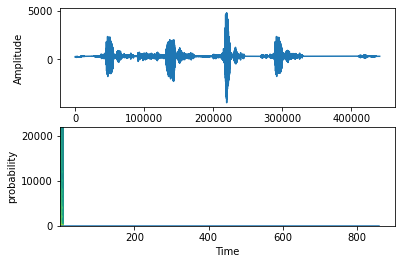

In [37]:
prediction = detect_triggerword("train.wav")
chime_on_activate("train.wav", prediction, 0.5)
IPython.display.Audio("./chime_output.wav")